In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os
import cv2
import pandas as pd
import time
from skimage.io import imread, imshow

In [2]:
'''This method will open an image object in a new window. Can be halted with the Escape key'''
def show_image_opencv_window(cv2_img_obj):
    cv2.imshow('image', cv2_img_obj)
    k = cv2.waitKey(0) & 0xFF
    if k == 27:
        cv2.destroyAllWindows()

In [3]:
'''This method uses matplotlib to show an image without any axis and by converting from BRG to RGB color
schemes to make sure image will match what it looks like in windows.'''
def show_image(image):
    #replace the next lines parameters with this code to convert from BGR to RGB
    # 'cv2.cvtColor(image, cv2.COLOR_BGR2RGB)'
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.show

In [4]:
#This directory needs to contain all the images in a single folder that you want to classify
parent_dir = 'C:/Users/Drake Coy/Desktop/Cogs 118b/Final Project/Animal Image Dataset (90 Different Animals)/animals_to_use'

#this code is used to import all of the images, convert them to gray-scale, and then adds them to an array
animals_gray = []
for filename in glob.glob(parent_dir + "/*.jpg"):
    im = imread(filename, as_gray = True)
    animals_gray.append(im)

In [5]:
#This directory needs to contain all the images in a single folder that you want to classify
parent_dir = 'C:/Users/Drake Coy/Desktop/Cogs 118b/Final Project/Animal Image Dataset (90 Different Animals)/animals_to_use'

#this code is used to import all of the images and add them to an array without converting to gray-scale
animals = []
for filename in glob.glob(parent_dir + "/*.jpg"):
    im = np.asarray(Image.open(filename))
    animals.append(im)

In [6]:
#we can see that 600 images were imported to be classified
len(animals)

600

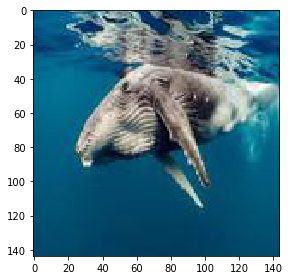

In [7]:
#use a PILLOW image method to view a random one of the images that we imported
imshow(animals[500])

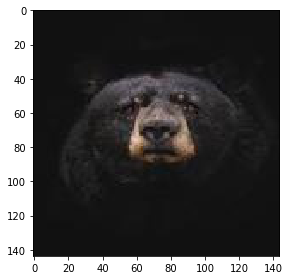

In [8]:
'''The next two images are included to note that there are some duplicate images in our dataset. They were originally of differing
resolutions, but since all images were compressed to be 144x144 they now appear the same. Lets see if they get classified the same!'''
imshow(animals[26])

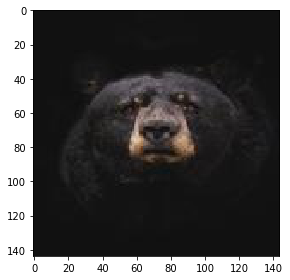

In [9]:
imshow(animals[13])

In [10]:
#Note: image shape is in the form (height, width, channels) where channels is 3 for all color images (BGR)
#you can see both images are 144x144
animals[26].shape, animals[13].shape

((144, 144, 3), (144, 144, 3))

In [11]:
#image size reports the total number of pixels in the image: 144x144x3
animals[0].size

62208

In [12]:
'''This runKMeans method was adapted from a previous assigment in my Cogs 118B class at UCSD, taken with Marcello Mattar. This
function is responsible for taking in the dataset of images to be classified and the number of clusters to make. It will then drive
the supporting functions by interating between calculating our distances and re-assigning out clusters.'''
def runKMeans(K, X, n_iters):
    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))
  
    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]
    
    #specify the maximum number of iterations to allow
    maxiters = n_iters

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #Rnk is the "responsibility" matrix
        #Rnk will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)
        
        KmusOld = Kmus
        '''Un-Comment this line if you would like to see a scatterplot after each iteration'''
        #plotCurrent(X, Rnk, Kmus)
        time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)

        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
            print(iter)
            break

    plotCurrent(X, Rnk, Kmus)
    return Rnk

In [13]:
'''This funtion is responsible for calculating the Euclidean distance between your data and your centroids. It will then return
a matrix of those distances.'''
def calcSqDistances(X, Kmus):
    output = np.zeros([np.shape(X)[0], np.shape(Kmus)[0]])
    for n in range(0, np.shape(output)[0]):
        for i in range(0, np.shape(output)[1]):
            output[n,i] = np.linalg.norm(X[n]- Kmus[i])

    return output

In [14]:
'''This funtion returns the responsibility matrix detailing which cluster/centroid each data point will be assigned to.'''
def determineRnk(sqDmat):
    output = np.zeros(np.shape(sqDmat))
    for n in range(np.shape(sqDmat)[0]):
        output[n][np.argmin(sqDmat[n])] = 1    
        
    return output

In [15]:
'''This function recalculates the centroids based upon the previous clustering assignments and will return the new centroids.'''
def recalcMus(X, Rnk):
    #empty matrix of Kmus size
    KmusNew = np.zeros([np.shape(Rnk)[1], np.shape(X)[1]])
    
    #matrix to contain sum of all asiigned points
    sumPoints = np.zeros([np.shape(Rnk)[1],np.shape(X)[1]])
    
    #matrix to contain the number of points in each cluster
    numPoints = np.zeros(np.shape(Rnk)[1])
    
    for i in range(np.shape(X)[0]):
        for j in range(np.shape(Rnk)[1]):
            if Rnk[i][j] == 1:
                sumPoints[j] += X[i]
                numPoints[j] += 1
                
    for k in range(np.shape(sumPoints)[0]):
        KmusNew[k] = sumPoints[k] / numPoints[k]
        
    return KmusNew
                

In [16]:
'''Plotcurrent gives a 2D depiction of all the datapoints in your dataset and how they are being clustered together. Each color
represents a different cluster, a diamond represents a centroid, and a circle is a singular datapoint.'''
def plotCurrent(X, Rnk, Kmus):
    N, D = X.shape
    K = Kmus.shape[0]

    InitColorMat = np.array([[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1],
                             [0, 0, 0],
                             [1, 1, 0],
                             [1, 0, 1],
                             [0, 1, 1],
                             [.5, 0, 0],
                             [0, .5, 0],
                             [0, 0, .5],])

    KColorMat = InitColorMat[0:K,:]

    colorVec = np.dot(Rnk, KColorMat)
    muColorVec = np.dot(np.eye(K), KColorMat)
    plt.scatter(X[:,0], X[:,1], c=colorVec)

    plt.scatter(Kmus[:,0], Kmus[:,1], s=200, c=muColorVec, marker='d')
    plt.axis('equal')
    plt.show()

In [17]:
#This directory needs to contain all the images in a single folder that you want to classify
parent_dir = 'C:/Users/Drake Coy/Desktop/Cogs 118b/Final Project/Animal Image Dataset (90 Different Animals)/animals_to_use'

#this code is used to import all of the images, calculate each images average B/G/R values, and then adds them to an array
animals_brg_channels = []
for filename in glob.glob(parent_dir + "/*.jpg"):
    im = cv2.imread(filename)
    channels = cv2.mean(im)
    animals_brg_channels.append(list(channels[0:3]))
    
animals_brg_channels = np.array(animals_brg_channels)

In [18]:
#You can see that the array contains an array of three values (Blue, Green, Red average pixel color) for each image
animals_brg_channels[0:3]

array([[ 69.82595486,  89.72612847, 112.68595679],
       [118.56505594, 105.63189622, 105.64472415],
       [154.64318094, 162.52445023, 176.40152392]])

In [19]:
#here we are adding all of our image data into a dataframe for better visualization/organization
animals_bgr = pd.DataFrame(data = animals_brg_channels)
animals_bgr['Image Data'] = animals
animals_bgr = animals_bgr.rename(columns={0: "Blue", 1: "Green", 2: "Red"})

In [20]:
animals_bgr

,Blue,Green,Red,Image Data
0,69.825955,89.726128,112.685957,"[[[37, 31, 9], [37, 31, 9], [37, 30, 11], [38,..."
1,118.565056,105.631896,105.644724,"[[[87, 92, 112], [76, 81, 101], [70, 76, 92], ..."
2,154.643181,162.524450,176.401524,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,63.035204,119.344088,96.366753,"[[[98, 109, 79], [76, 91, 50], [95, 115, 52], ..."
4,78.972656,85.383922,99.874325,"[[[214, 213, 218], [214, 213, 218], [214, 213,..."
...,...,...,...,...
595,64.172454,73.109086,81.887008,"[[[8, 0, 2], [10, 1, 4], [11, 2, 5], [10, 1, 2..."
596,215.150125,225.926794,227.668499,"[[[216, 217, 211], [216, 217, 211], [217, 218,..."
597,117.011333,120.107205,117.651669,"[[[170, 178, 181], [174, 182, 185], [176, 184,..."
598,98.230758,119.538725,115.298708,"[[[101, 104, 77], [122, 125, 98], [116, 119, 9..."


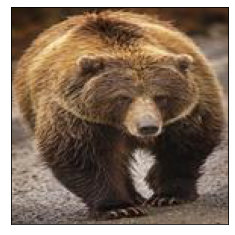

In [21]:
#we have a new way of accessing our images through the dataset
show_image(animals_bgr.loc[0].at["Image Data"])

In [22]:
#here we are beginning the K-Means classification by defining our dataset and its shape into independent variables
X = animals_bgr.iloc[:, [0, 1, 2]].values
m = X.shape[0]
n = X.shape[1]

#we are choosing our maximum number of iterations here
n_iter = 10

#we will choose to have 10 clusters as our dataset contains images of 10 different animals
K = 1000

In [23]:
#we are confirming that our dataset has all 600 images with their 3 average color values
X.shape

(600, 3)

13


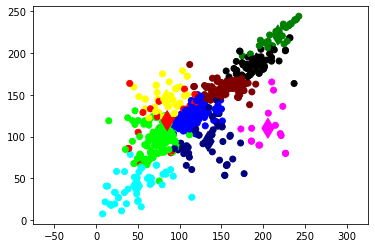

In [24]:
#This code will run our K-Means algorithm and store the cluster assigment of each image into an array
cluster_assignments = runKMeans(10, X, K)

#The returned scatterplot is only showing the final clustering. You can uncomment the noted line in "RunKMeans" to view a scatterplot
# after each iteration.

In [25]:
#here we are converting the returned rank matrix into an array with each cluster being numbered 0-9
cluster_assignment_numbers = []
for point in cluster_assignments:
    cluster_num = np.where(point == 1)[0][0]
    cluster_assignment_numbers.append(cluster_num)

In [26]:
#we can then add our cluster numbers to their assigned images in the dataframe created earlier
animals_bgr["Cluster Number"] = cluster_assignment_numbers

In [27]:
#here we are defining a path with precreated folders named 'Cluser_0' through 'Cluster_9'
root_path = 'C:/Users/Drake Coy/Desktop/Cogs 118b/Final Project/Animal Image Dataset (90 Different Animals)/final_clusters/'

#this code will save all the clustered images in our dataset into the above folders based upon their assignment
counter = 0
for image in range(600):
    im = Image.fromarray(animals_bgr.iloc[image].at["Image Data"])
    im.save(root_path + 'cluster_' + str(animals_bgr.iloc[image].at["Cluster Number"]) + '/' + str(counter) + '.jpg')
    counter += 1

In [28]:
#lets see our dataframe again and how each image was classified
animals_bgr

,Blue,Green,Red,Image Data,Cluster Number
0,69.825955,89.726128,112.685957,"[[[37, 31, 9], [37, 31, 9], [37, 30, 11], [38,...",1
1,118.565056,105.631896,105.644724,"[[[87, 92, 112], [76, 81, 101], [70, 76, 92], ...",2
2,154.643181,162.524450,176.401524,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",7
3,63.035204,119.344088,96.366753,"[[[98, 109, 79], [76, 91, 50], [95, 115, 52], ...",1
4,78.972656,85.383922,99.874325,"[[[214, 213, 218], [214, 213, 218], [214, 213,...",1
...,...,...,...,...,...
595,64.172454,73.109086,81.887008,"[[[8, 0, 2], [10, 1, 4], [11, 2, 5], [10, 1, 2...",1
596,215.150125,225.926794,227.668499,"[[[216, 217, 211], [216, 217, 211], [217, 218,...",8
597,117.011333,120.107205,117.651669,"[[[170, 178, 181], [174, 182, 185], [176, 184,...",2
598,98.230758,119.538725,115.298708,"[[[101, 104, 77], [122, 125, 98], [116, 119, 9...",2


In [29]:
#as a quick check, you can replace the two variables below with images of the same cluster number and run the next two cells to view
#if your images were classified correctly

image_num_one = 597
image_num_two = 598

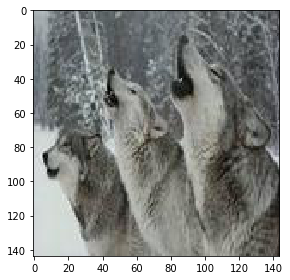

In [30]:
imshow(animals_bgr.iloc[image_num_one].at["Image Data"])

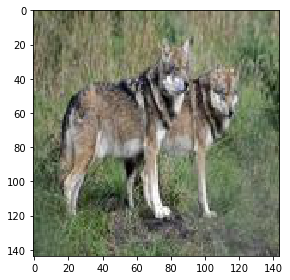

In [31]:
imshow(animals_bgr.iloc[image_num_two].at["Image Data"])

### **References:**

This is the textbook we used in Marcello Mattars COGS 118B Class as UCSD
#### Bishop, C. M. (2016). Pattern recognition and machine learning. Springer.

### **Random Articles:**
These are just some random articles I found while looking for inspiration/extra info. Nothing was directly incorporated into the project above.

https://stackoverflow.com/questions/39123421/image-clustering-by-its-similarity-in-python  
https://www.kdnuggets.com/2019/08/introduction-image-segmentation-k-means-clustering.html  
https://keras.io/api/applications/#usage-examples-for-image-classification-models  
https://www.analyticsvidhya.com/blog/2019/08/3-techniques-extract-features-from-image-data-machine-learning-python/  
